# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Mateo Garcia

**Professor**: Pablo Camarillo Ramirez

In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://5fcc419ae5b6:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [8]:
# Build schema
# Import your module
from mateogarcial.spark_utils import SparkUtils
from pyspark.sql.functions import get_json_object

schema_agencies = SparkUtils.generate_schema([("agency_id", "int"), ("agency_info", "string")])
schema_cars = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
schema_customers = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
schema_rental_cars = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

_path = "/opt/spark/work-dir/data/car_service/"

df_agencies = spark.read \
                .schema(schema_agencies) \
                .option("header", "true") \
                .csv(_path + "agencies")
df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, "$.agency_name"))

df_cars = spark.read.schema(schema_cars).option("header", True).csv(_path + "cars")
df_customers = spark.read.schema(schema_customers).option("header", True).csv(_path + "customers")
df_rental_cars = spark.read.schema(schema_rental_cars).option("header", True).csv(_path + "rentals")
df_brands = spark.read.schema(schema_agencies).option("header", True).csv(_path + "brands")

df_agencies.show(truncate=False)
df_cars.show(truncate=False)
df_customers.show(truncate=False)
df_rental_cars.show(truncate=False)
df_brands.show(truncate=False)

+---------+-----------------------------------------------------+-------------+
|agency_id|agency_info                                          |agency_name  |
+---------+-----------------------------------------------------+-------------+
|1        |{'agency_name': 'NYC Rentals', 'city': 'New York'}   |NYC Rentals  |
|2        |{'agency_name': 'LA Car Rental', 'city': 'Londres'}  |LA Car Rental|
|3        |{'agency_name': 'Zapopan Auto', 'city': 'Zapopan'}   |Zapopan Auto |
|4        |{'agency_name': 'SF Cars', 'city': 'San Francisco'}  |SF Cars      |
|5        |{'agency_name': 'Mexico Cars', 'city': 'Mexico City'}|Mexico Cars  |
+---------+-----------------------------------------------------+-------------+

+------+----------------------------------------------------------------------------------------+
|car_id|car_info                                                                                |
+------+---------------------------------------------------------------------------

In [9]:
df_agencies = df_agencies.withColumn("agency_name", get_json_object(df_agencies.agency_info, "$.agency_name")).drop("agency_info")
df_cars = df_cars.withColumn("car_name", get_json_object(df_cars.car_info, "$.car_name")).drop("car_info")
df_customers = df_customers.withColumn("customer_name", get_json_object(df_customers.customer_info, "$.customer_name")).drop("customer_info")

df_rental_cars = df_rental_cars.withColumn("car_id", get_json_object(df_rental_cars.rental_info, '$.car_id')) \
                            .withColumn("customer_id", get_json_object(df_rental_cars.rental_info, '$.customer_id')) \
                            .withColumn("agency_id", get_json_object(df_rental_cars.rental_info, '$.agency_id')) \
                            .drop("rental_info")

df_rental_cars = df_rental_cars.join(df_cars, on="car_id", how="left") \
                                .join(df_agencies, on="agency_id", how="left") \
                                .join(df_customers, on="customer_id", how="left") \
                                .drop("agency_id", "customer_id", "car_id")

df_rental_cars.show(5)

+---------+--------------------+-------------+---------------+
|rental_id|            car_name|  agency_name|  customer_name|
+---------+--------------------+-------------+---------------+
|    11891|Wallace-Carlson M...|  NYC Rentals| Margaret Jones|
|    11892|Grimes-Green Model 8|LA Car Rental|Albert Williams|
|    11893|Stewart-Allen Mod...|      SF Cars|  Caleb Fleming|
|    11894|  Campos PLC Model 4|  NYC Rentals|  Andrew Butler|
|    11895|  Wagner LLC Model 1|      SF Cars|  Kristin Potts|
+---------+--------------------+-------------+---------------+
only showing top 5 rows


In [10]:
df_rental_cars.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(_path + "output/csv")

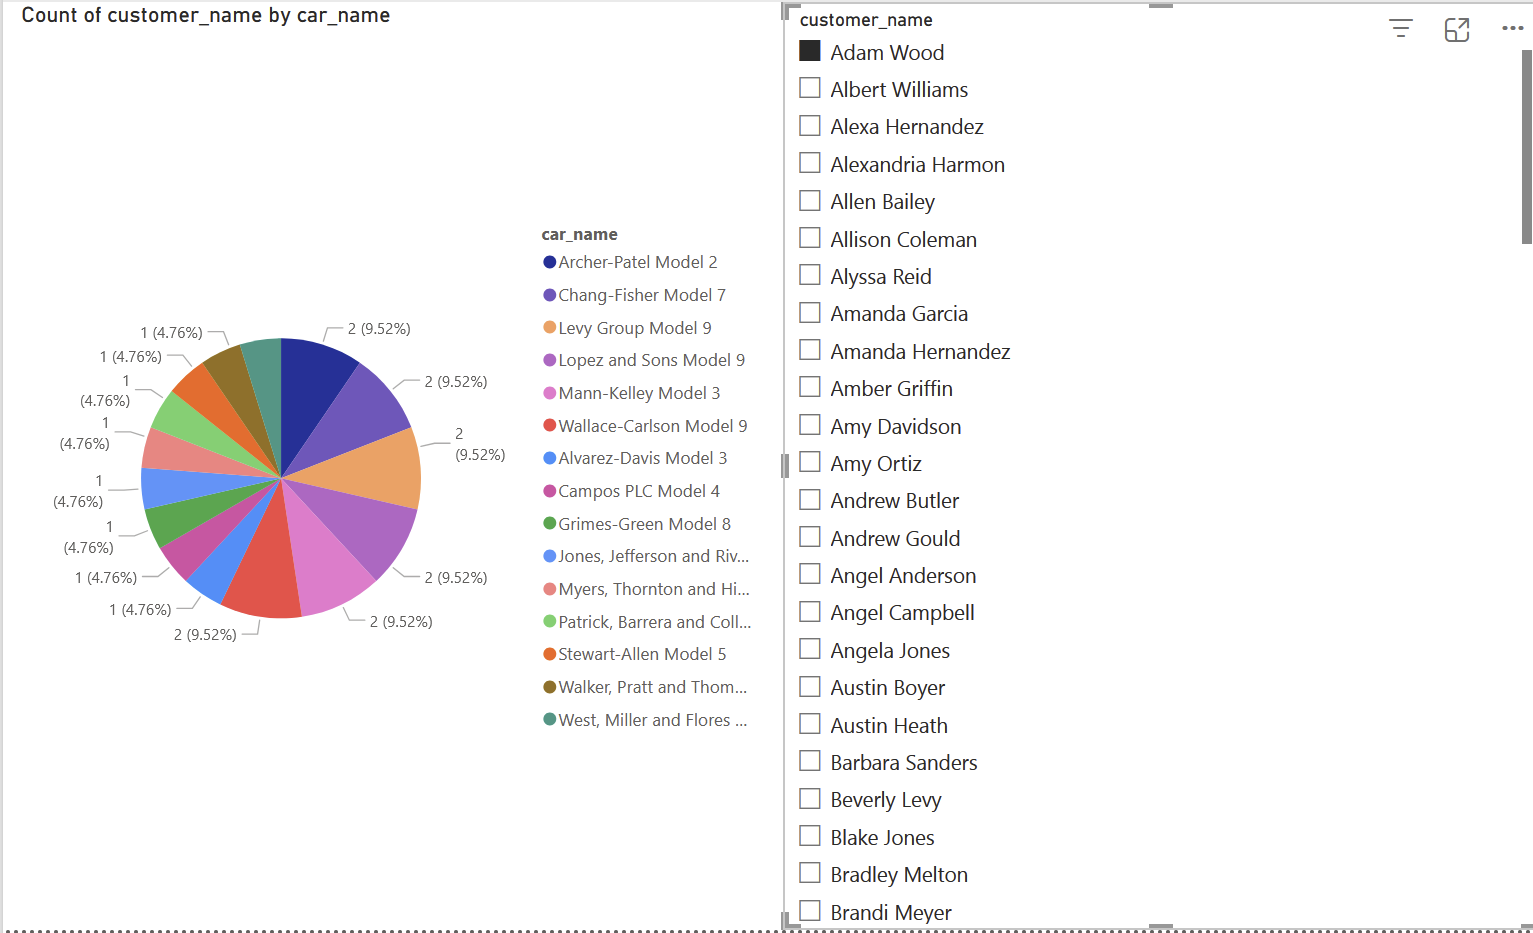

In [2]:
sc.stop()